In [1]:
import re
import inflect
import string

from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
stemmer = PorterStemmer()

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
def text_lowercase(text):
    return text.lower()

p = inflect.engine()

# convert number into words
def convert_number(text):
    # split string into list of words
    temp_str = text.split()
    # initialise empty list
    new_string = []

    for word in temp_str:
        # if word is a digit, convert the digit
        # to numbers and append into the new_string list
        if word.isdigit():
            temp = p.number_to_words(word)
            new_string.append(temp)

        # append the word as it is
        else:
            new_string.append(word)

    # join the words of new_string to form a string
    temp_str = ' '.join(new_string)
    return temp_str

def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

def remove_whitespace(text):
    return  " ".join(text.split())

# remove stopwords function
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return filtered_text

# stem words in the list of tokenized words
def stem_words(text):
    word_tokens = word_tokenize(text)
    stems = [stemmer.stem(word) for word in word_tokens]
    return stems

# lemmatize string
def lemmatize_word(text):
    word_tokens = word_tokenize(text)
    # provide context i.e. part-of-speech
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in word_tokens]
    return lemmas

def rejoin(text):
    return ' '.join(text)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd /content/drive/MyDrive/ds6050/git/

/content/drive/MyDrive/ds6050/git


In [5]:
import matplotlib.pyplot as plt, numpy as np, os, pandas as pd, seaborn as sns
df = pd.read_feather("data-extractor/data/dataset.feather")
df['topic'] = df['topic'].str.split('.').str[0]

values = df.summary.apply(text_lowercase).apply(convert_number).apply(remove_punctuation)\
           .apply(remove_whitespace).apply(remove_stopwords).apply(rejoin).apply(lemmatize_word)

values

0        [astronomical, object, celestial, object, natu...
1        [ida, minor, planet, designation, two, hundred...
2        [eros, minor, planet, designation, 433, eros, ...
3        [active, galactic, nucleus, agn, compact, regi...
4        [algol, variables, algoltype, binaries, class,...
                               ...                        
45025    [word, processor, wp, device, computer, progra...
45026    [work, animal, animal, usually, domesticate, k...
45027    [world, wide, web, www, commonly, know, web, i...
45028    [edit, process, select, prepare, write, photog...
45029    [tin, chemical, element, symbol, sn, latin, st...
Name: summary, Length: 45030, dtype: object

In [6]:
import lightgbm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer

In [7]:
le = preprocessing.LabelEncoder()
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(values.apply(rejoin))
y = le.fit_transform(df['topic'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_data = lightgbm.Dataset(X_train, label=y_train)
test_data = lightgbm.Dataset(X_test, label=y_test)

params = {'num_leaves': 31, 'objective': 'multiclass', 'seed' : 42, 'num_class': 7}

num_round = 10
bst = lightgbm.train(params, train_data, num_round, valid_sets = [test_data])

[1]	valid_0's multi_logloss: 1.80624
[2]	valid_0's multi_logloss: 1.7157
[3]	valid_0's multi_logloss: 1.6435
[4]	valid_0's multi_logloss: 1.58183
[5]	valid_0's multi_logloss: 1.52943
[6]	valid_0's multi_logloss: 1.484
[7]	valid_0's multi_logloss: 1.44451
[8]	valid_0's multi_logloss: 1.40931
[9]	valid_0's multi_logloss: 1.37862
[10]	valid_0's multi_logloss: 1.34977


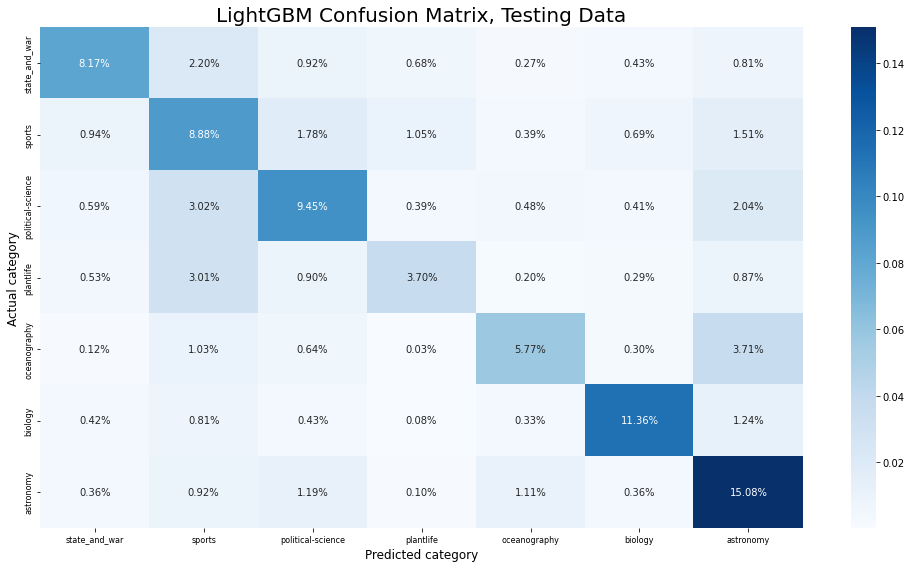

In [8]:
labels = list(df['topic'].unique())
labels.sort()
x_labs = labels
labels.sort(reverse = True)
y_labs = labels

def plot_cm(cm, title = 'Confusion Matrix'):
  fig = plt.figure(figsize = (14,8))
  ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues');
  # labels, title and ticks
  ax.set_xlabel('Predicted category', fontsize = 12);
  ax.set_ylabel('Actual category', fontsize = 12); 
  ax.set_title(title, fontsize = 20); 
  ax.xaxis.set_ticklabels(x_labs, fontsize = 8); 
  ax.yaxis.set_ticklabels(y_labs, fontsize = 8);

  ax.set_facecolor('w')
  fig.set_facecolor('w')
  
  plt.tight_layout()
  plt.show()

y_pred = bst.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)
  
test_cm = confusion_matrix(y_test, y_pred)
plot_cm(test_cm, 'LightGBM Confusion Matrix, Testing Data')

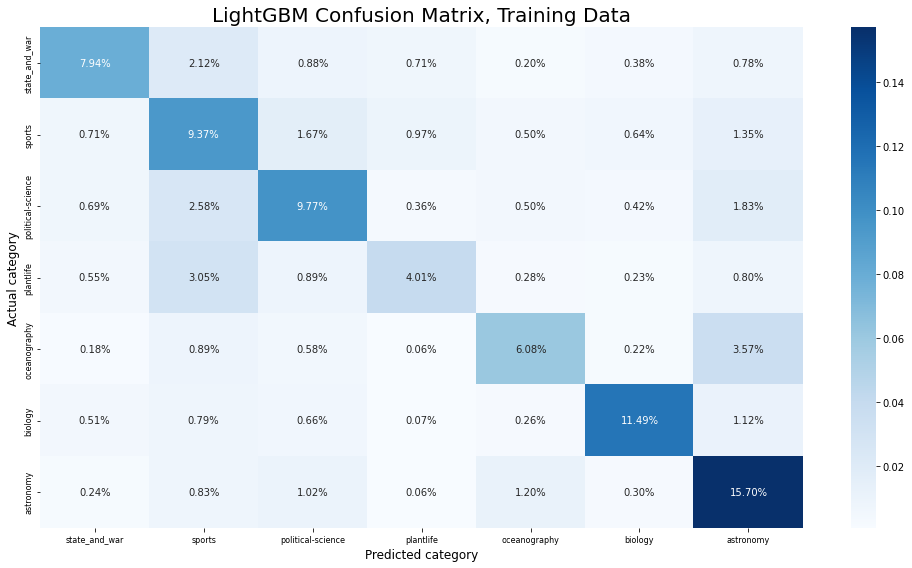

In [9]:
train_cm = confusion_matrix(y_train, np.argmax(bst.predict(X_train), axis = 1))
plot_cm(train_cm, 'LightGBM Confusion Matrix, Training Data')

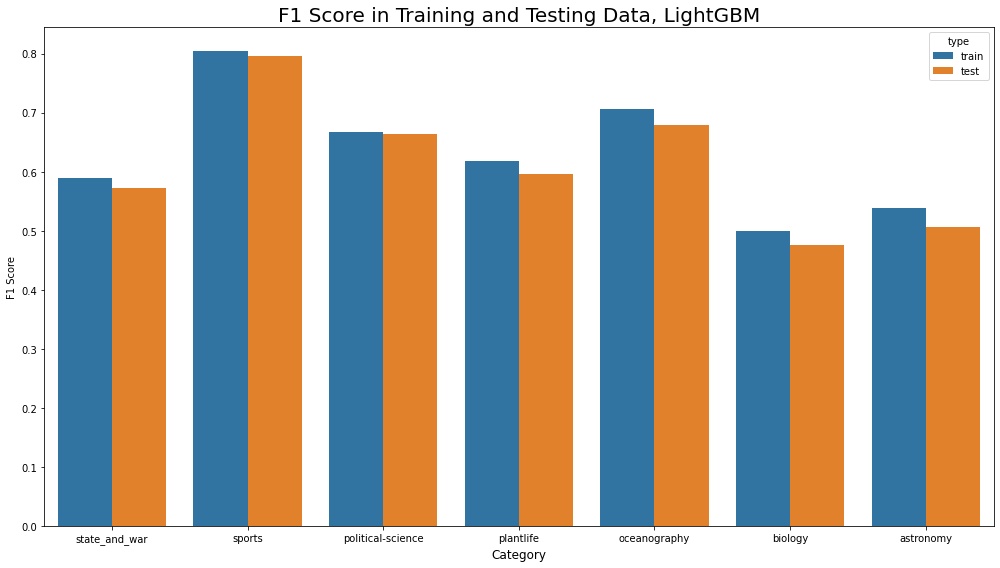

In [10]:
## plotting f1 scores
test_f1  = f1_score(y_test,  y_pred, average = None)
train_f1 = f1_score(y_train, np.argmax(bst.predict(X_train), axis = 1), average = None)

test_f1  = pd.Series(test_f1).reset_index()\
             .rename(columns = {'index': 'category', 0: 'f1'})
train_f1 = pd.Series(train_f1).reset_index()\
             .rename(columns = {'index': 'category', 0: 'f1'})
test_f1['type']  = 'test'
train_f1['type'] = 'train'
lightgbm_f1 = pd.concat([train_f1, test_f1]).reset_index(drop = True)\
                .replace({'category': {t: idx for idx, t in zip(sorted(df['topic'].unique()), range(7))}})\
                .sort_values(by = ['category', 'type'], ascending = False)

# plotting
fig = plt.figure(figsize = (14,8))
# can't get it to sort alphabetically for some reason
ax = sns.barplot(x = 'category', y = 'f1', hue = 'type', 
                 data = lightgbm_f1, order = list(set(lightgbm_f1.category)));
# labels, title and ticks
ax.set_xlabel('Category', fontsize = 12);
ax.set_ylabel('F1 Score'); 
ax.set_title('F1 Score in Training and Testing Data, LightGBM', fontsize = 20); 
ax.xaxis.set_ticklabels(labels); 

ax.set_facecolor('w')
fig.set_facecolor('w')

plt.tight_layout()
plt.show()

In [11]:
accuracy_score(y_test, y_pred)

0.6241394625805019